In [20]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import SVG

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm

from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

from pandas.api.types import CategoricalDtype

In [2]:
PATH_TO_DATA = '../datasets/porto-seguros-safe-driver-prediction-files'

### Load Data

In [3]:
Xy_all = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'), nrows=100000)
X_all = Xy_all.drop(columns=['id','target'])
y_all = Xy_all['target']

del Xy_all

### Preprocessing

##### Get different coloumn types

In [4]:
cat_cols = [col for col in X_all if col.endswith('_cat')]
bin_cols = [col for col in X_all if col.endswith('_bin')]
other_cols = [col for col in X_all.columns if ((not col in cat_cols) and (not col in bin_cols))]

##### Encode categorical variables

In [5]:
X_all[cat_cols] = X_all[cat_cols].astype('category')

cat_cols_coded = []
for col in cat_cols:
    X_all[col + '_coded'] = X_all[col].cat.codes
    cat_cols_coded.append(col+'_coded')

##### Train/Val/Test split

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X_all, y_all):
    XX_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    yy_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]
    
del X_all
del y_all

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=43)

for train_index, test_index in sss.split(XX_train, yy_train):
    X_train, X_val = XX_train.iloc[train_index], XX_train.iloc[test_index]
    y_train, y_val = yy_train.iloc[train_index], yy_train.iloc[test_index]
    
del XX_train
del yy_train

#### Check for missing values

In [7]:
for col in X_train.columns:
    miss = X_train[X_train[col] == -1][col].count()
    if miss > 0:
        miss_perc = miss/X_train.shape[0]
        
        print(f'Variable {col} has {miss} records ({miss_perc:.2%}) with missing values')

Variable ps_ind_02_cat has 20 records (0.03%) with missing values
Variable ps_ind_04_cat has 7 records (0.01%) with missing values
Variable ps_ind_05_cat has 637 records (0.94%) with missing values
Variable ps_reg_03 has 12310 records (18.10%) with missing values
Variable ps_car_01_cat has 7 records (0.01%) with missing values
Variable ps_car_03_cat has 46900 records (68.97%) with missing values
Variable ps_car_05_cat has 30373 records (44.67%) with missing values
Variable ps_car_07_cat has 1262 records (1.86%) with missing values
Variable ps_car_09_cat has 60 records (0.09%) with missing values
Variable ps_car_14 has 4840 records (7.12%) with missing values


##### Delete empty columns

In [8]:
cols_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']

X_train.drop(columns=cols_to_drop, inplace=True)
X_val.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)

##### Imputing mean or most frequent values

In [9]:
imp_medi = SimpleImputer(missing_values=-1, strategy='median')
X_train['ps_reg_03'] = imp_medi.fit_transform(X_train[['ps_reg_03']])

X_val['ps_reg_03'] = imp_medi.transform(X_val[['ps_reg_03']])
X_test['ps_reg_03'] = imp_medi.transform(X_test[['ps_reg_03']])

In [10]:
imp_mode = SimpleImputer(missing_values=-1, strategy='most_frequent')
X_train['ps_car_14'] = imp_mode.fit_transform(X_train[['ps_car_14']])

X_val['ps_car_14'] = imp_mode.transform(X_val[['ps_car_14']])
X_test['ps_car_14'] = imp_mode.transform(X_test[['ps_car_14']])

##### Scale other variables (dtype float)

In [11]:
scaler = StandardScaler()

other_cols_scaled = []
for col in other_cols:
    
    if X_train[col].dtype == 'float64':
        X_train[col + '_scaled'] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
        X_val[col + '_scaled'] = scaler.transform(X_val[col].values.reshape(-1, 1))
        X_test[col + '_scaled'] = scaler.transform(X_test[col].values.reshape(-1, 1))
        other_cols_scaled.append(col+'_scaled')

## Model with embedding

In [12]:
def create_embedding_model():
    inputs = []
    models = []
    
    for cat_col in cat_cols_coded:
        
        cat_input = Input(shape=(1,))
        
        no_of_unique_cat  = X_train[cat_col].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        vocab  = no_of_unique_cat+1
        
        embedding = Embedding(vocab ,embedding_size)(cat_input)
        embedding = Reshape(target_shape=(embedding_size,))(embedding)
        
        inputs.append(cat_input)
        models.append(embedding)
    
    bin_input = Input(shape=(len(bin_cols),), name='binned')
    bin_model = Dense(int(len(bin_cols)/2),  activation='relu', kernel_constraint=max_norm(4.),
                        name='bin_dense')(bin_input)
    
    inputs.append(bin_input)
    models.append(bin_model)
    
    other_input = Input(shape=(len(other_cols),), name='other')
    other_model = Dense(int(len(bin_cols)/2), activation='relu', kernel_constraint=max_norm(4.),
                        name='other_dense')(other_input)
    
    inputs.append(other_input)
    models.append(other_model)
    
    full_model = Concatenate()(models)
    full_model = Dense(55, activation='relu', kernel_constraint=max_norm(4.))(full_model)
    full_model = Dropout(.35)(full_model)
    full_model = Dense(10, activation='relu', kernel_constraint=max_norm(4.))(full_model)
    full_model = Dropout(.15)(full_model)
    
    output = Dense(1, activation='sigmoid')(full_model)
    
    model = Model(inputs, output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model      
        

In [13]:
emb_model = create_embedding_model()
emb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

In [14]:
def prepare_nn_input(X_data):
    nn_input = []
    for col in cat_cols_coded:
        nn_input.append(X_data[col].values)
    
    bin_input = X_data[bin_cols].values
    other_input = X_data[other_cols].values
    
    nn_input.append(bin_input)
    nn_input.append(other_input)
    return nn_input

In [15]:
nn_train_input = prepare_nn_input(X_train)
nn_val_input = prepare_nn_input(X_val)
nn_test_input = prepare_nn_input(X_test)

In [16]:
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]

tradeoff = 0.6
weight = tradeoff * neg_count/pos_count

class_weights = {0: 1.,
                1: weight
               }

val_weights = y_val.values * weight
val_weights[val_weights == 0] = 1

val_data = (nn_val_input, y_val, val_weights)

emb_model = create_embedding_model()
emb_model_fitted = emb_model.fit(nn_train_input, y_train,
                                 class_weight=class_weights, 
                                 validation_data = val_data,
                                 batch_size=32, epochs= 50)

Train on 68000 samples, validate on 12000 samples
Epoch 1/50
68000/68000 [==============================] - 6s 87us/step - loss: 1.0222 - acc: 0.9554 - val_loss: 0.9979 - val_acc: 0.9633
Epoch 2/50
68000/68000 [==============================] - 5s 76us/step - loss: 1.0021 - acc: 0.9549 - val_loss: 0.9910 - val_acc: 0.9239
Epoch 3/50
68000/68000 [==============================] - 5s 74us/step - loss: 0.9950 - acc: 0.9052 - val_loss: 0.9934 - val_acc: 0.9011
Epoch 4/50
68000/68000 [==============================] - 5s 74us/step - loss: 0.9881 - acc: 0.9009 - val_loss: 0.9893 - val_acc: 0.8848
Epoch 5/50
68000/68000 [==============================] - 5s 73us/step - loss: 0.9845 - acc: 0.8953 - val_loss: 0.9898 - val_acc: 0.9073
Epoch 6/50
68000/68000 [==============================] - 5s 73us/step - loss: 0.9802 - acc: 0.9015 - val_loss: 0.9934 - val_acc: 0.8865
Epoch 7/50
68000/68000 [==============================] - 5s 74us/step - loss: 0.9736 - acc: 0.8969 - val_loss: 0.9908 - val_acc

In [29]:
y_proba = emb_model.predict(nn_test_input)

threshold = 0.6
y_classes = (y_proba > threshold).flatten().astype('int32')

print(classification_report(y_test, y_classes, digits=4))

              precision    recall  f1-score   support

           0     0.9644    0.9492    0.9567     19266
           1     0.0560    0.0790    0.0655       734

   micro avg     0.9173    0.9173    0.9173     20000
   macro avg     0.5102    0.5141    0.5111     20000
weighted avg     0.9310    0.9173    0.9240     20000



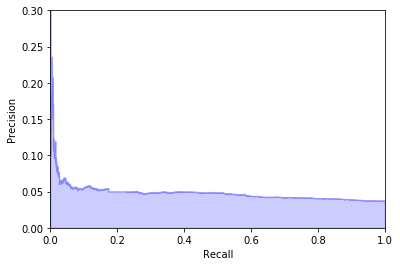

In [24]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, .3])
plt.xlim([0.0, 1.0])
plt.show()